In [1]:
from __future__ import print_function
from math import cos, sin, pi, atan2
from copy import deepcopy

import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

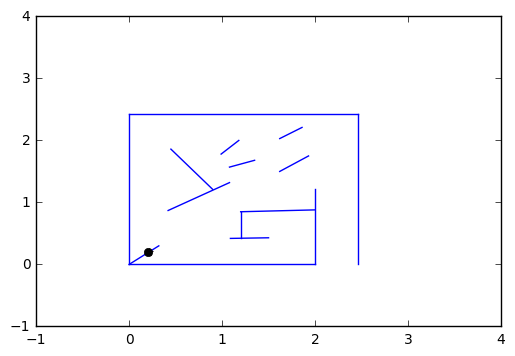

In [2]:
class Map:
    
    def __init__(self, map_path=None):
        self.edges = []

        # Read map from text file
        if map_path:
            with open(map_path) as f:
                for line in f:
                    if line[0] == '#':
                        continue
                    self.add_edge(*[float(c) for c in line.split()])
                    
    def add_obstacle(self, obstacle):
        pass
    
    def plot(self):
        for x1, y1, x2, y2 in self.edges:
            plt.plot([x1, x2], [y1, y2], 'b')
    
    def add_edge(self, x1, y1, x2, y2):
        self.edges.append((x1, y1, x2, y2))
        
    def scan_one(self, x, y, theta, alpha):
        """returns distances for one angle
        x, y: float
             position in meters
        theta: float
            robot rotation in radians
        alpha: float
            in what direction, relative to robot, to scan
        """
        n = len(self.edges)
        distances = np.zeros(n)
        for i, edge in enumerate(self.edges):
            dist = self._distance(x, y, theta, alpha, *edge)
            distances[i] = dist
        
        return np.min(distances)
    
    def _distance(self, x1, x2, theta, alpha, a1, a2, b1, b2):
        """
        Returns distance given one position, one edge, and an angle alpha
        """
        a = np.array([[a1, a2]]).T
        b = np.array([[b1, b2]]).T
        x = np.array([[x1, x2]]).T
        try:
            k = 1.0 / ((a2 - b2) * cos(theta + alpha) + sin(theta + alpha) * (b1 - a1))
            A = np.array([
                [ a2 - b2   , b1 - a1   ],
                [-sin(theta + alpha), cos(theta + alpha)]
            ])
            s, t = (k * np.dot(A, (a - x))).flatten()
            if 0 <= t <= 1 and 0 < s:
                return s
        except ZeroDivisionError:
            pass
        return np.inf
        
m = Map(map_path='map.txt')

def angle_to_rad(angle):
    return np.pi * angle / 180.0

x, y = 0.2, 0.2
alpha, theta = angle_to_rad(-45), angle_to_rad(45)
distance = m.scan_one(x, y, theta, alpha)
plt.plot(x + distance * cos(alpha + theta), y + distance * sin(alpha + theta), 'r*')
m.plot()
plt.plot(x, y, 'ko')
plt.xlim((-1, 4))
plt.ylim((-1, 4))
plt.show()

0.893341612958


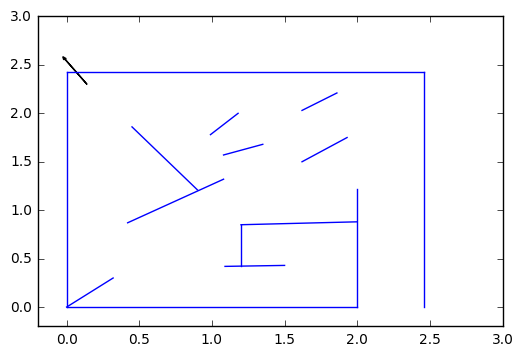

In [3]:
class Particle:
    
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        
    def update(self, forward_delta, delta_theta):
        self.theta += delta_theta + np.random.normal(0, 0.08)
        forward_noise = np.random.normal(0, abs(forward_delta * 0.1) + 0.1)
        self.x += np.cos(self.theta) * (forward_delta + forward_noise)
        self.y += np.sin(self.theta) * (forward_delta + forward_noise)
        
    def __repr__(self):
        return 'Particle at: {} {} {}'.format(self.x, self.y, self.theta)
    
    def likelihood(self, lidar_coords, map_):
        dists = []
        for x, y in lidar_coords:
            if np.abs(x) == np.inf or np.abs(y) == np.inf:
                continue
            alpha = atan2(-x, y)
            dist = map_.scan_one(self.x, self.y, self.theta, alpha)
            #                 measured             expected
            dists.append(abs(np.sqrt(x ** 2 + y ** 2) - dist))
        dists.sort()
        return np.exp(-sum(dists[:20]))
        
    def plot(self):
        plt.plot(self.x, self.y, 'k.')
        
x, y, theta = 0.14, 2.3, 2.1
p = Particle(x, y, theta)
coords = np.array([
    [0, 0.1],
    [-0.1, 0],
])
print(p.likelihood(coords, m))

m.plot()
plt.xlim((-0.2, 3))
plt.ylim((-0.2, 3))
plt.arrow(x, y, 0.3 * np.cos(theta), 0.3 * np.sin(theta))
plt.show()

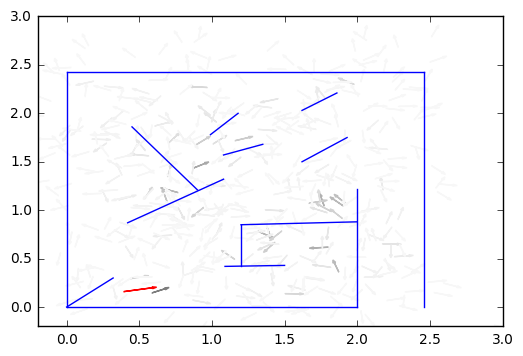

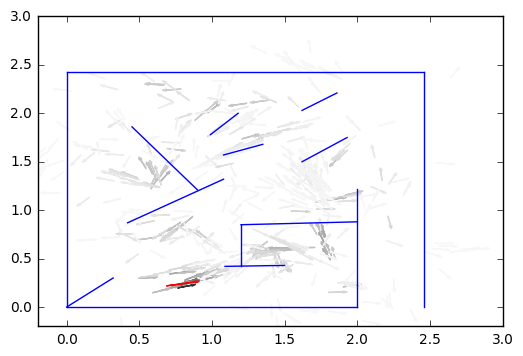

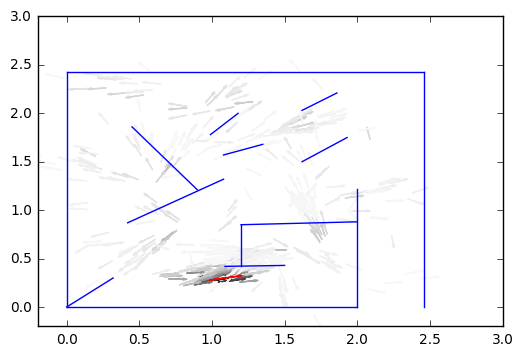

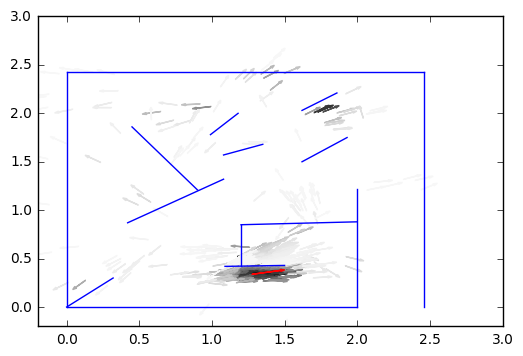

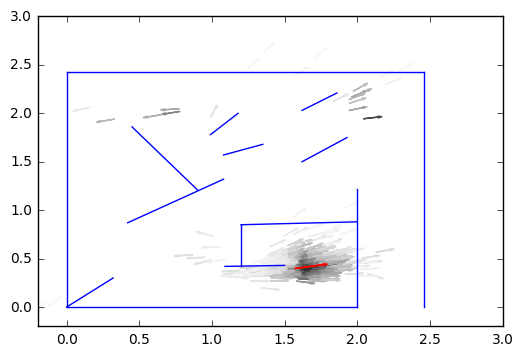

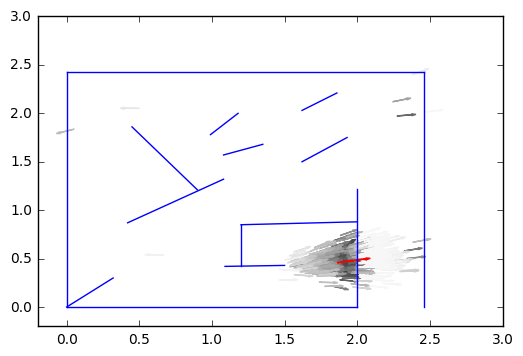

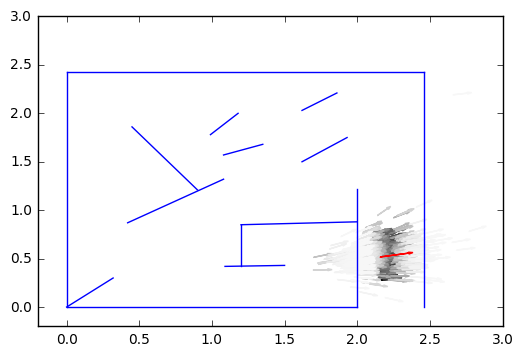

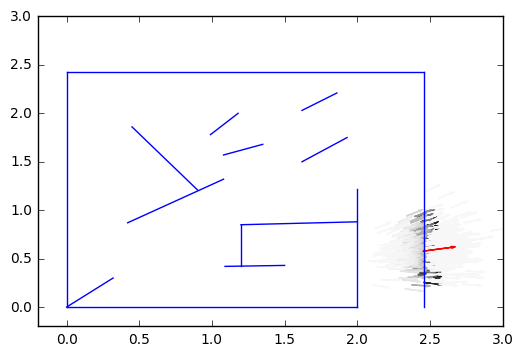

In [4]:
class ParticleFilter:
    
    def __init__(
        self,
        n_particles=32,
        xlim=(0, 2.4),
        ylim=(0, 2.5),
        thetalim=(0, 2 * np.pi)
    ):
        self.particles = [
            Particle(
                np.random.rand() * (xlim[1] - xlim[0]) + xlim[0],
                np.random.rand() * (ylim[1] - ylim[0]) + ylim[0],
                np.random.rand() * (thetalim[1] - thetalim[0]) + thetalim[0],
            )
            for _ in range(n_particles)
        ]
            
    def plot(self):
        for p in self.particles:
            plt.arrow(
                p.x,
                p.y,
                0.1 * np.cos(p.theta),
                0.1 * np.sin(p.theta)
            )
            
    def resample(self, lidar_coords, map_, n_samples):
        weights = np.zeros(len(self.particles))
        for i, p in enumerate(self.particles):
            weights[i] = p.likelihood(lidar_coords, map_)
        weights /= weights.sum()
        samples = np.random.multinomial(n_samples, weights)
        
        new_particles = []
        for particle_index, n_copies in enumerate(samples):
            for n in range(n_copies):
                new_particles.append(deepcopy(self.particles[particle_index]))
                
        self.particles = new_particles
            
    def update(self, delta_forward, delta_theta):
        for p in self.particles:
            p.update(delta_forward, delta_theta)
        

n_particles = 512
pf = ParticleFilter(n_particles=n_particles)
x, y, theta = 0.1, 0.1, 0.2
dx = 0.3 * np.cos(theta)
dy = 0.3 * np.sin(theta)
for i in range(8):
    x += dx
    y += dy
    m.plot()
    plt.xlim((-0.2, 3))
    plt.ylim((-0.2, 3))
    pf.update(np.sqrt(dx ** 2 + dy ** 2), 0)
    lidar_coords = [
        m.scan_one(x, y, theta, alpha) * np.array([-np.sin(alpha), np.cos(alpha)])
        for alpha in np.linspace(0, 2 * np.pi, 32)
    ]
    scored = sorted([(p.likelihood(lidar_coords, m), p) for p in pf.particles], reverse=True)
    for score, p in scored:
        plt.arrow(
            p.x, p.y, 0.1 * np.cos(p.theta), 0.1 * np.sin(p.theta),
            color=str(0.97 * (1 - score) ** 2)
        )
    plt.arrow(x, y, 0.2 * np.cos(theta), 0.2 * np.sin(theta), color='r')
    plt.show()
    pf.resample(lidar_coords, m, n_particles)